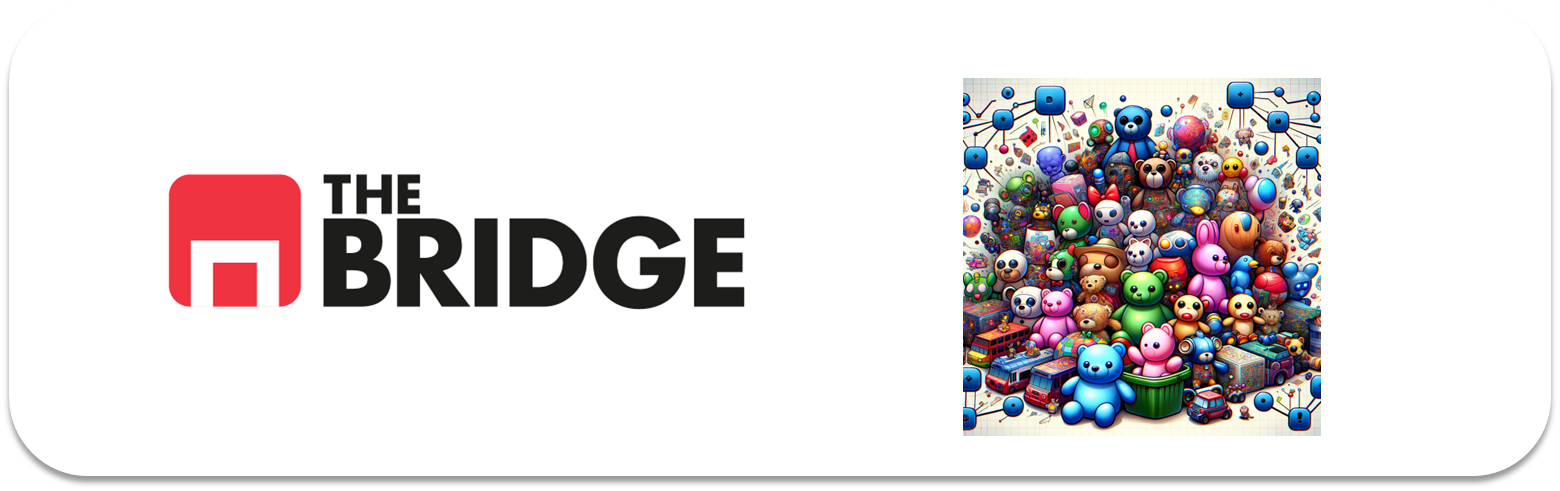

## PRACTICA OBLIGATORIA: **DBSCAN y Clustering Jerárquico**

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado aplicado a clustering jerárquico y no jerárquico. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [32]:
import pandas as pd
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN


pd.options.mode.copy_on_write = True

### Parte I. Modelado

#### Descripción del problema.

En una planta de experimentación con nuevas bebidas energéticas están trabajando con diferentes mezclas de componentes para obtener posibles variedades de su producto estrella "NonstopU". El problema es que la fabricación de cada "prototipo" conlleva demasiado tiempo y las pruebas de sabores y de propiedades "non-stop" antisueño y antifatiga son costosas.  

En ese sentido quieren construir algún sistema de segmentación previa de mezclas sin probarlas solo indicando las cantidades de cada componente de la bebida. Tienen datos pero desgraciadamente de mezclas anteriores con diferentes medidas pero que por temas presupuestarios y de prioridad no se hicieron test con usuarios y potenciales clientes, es decir no tienen un target de capacidad antifatiga o de preferncia del usuario que puedas servirles para construir un clasificador clásico como han hecho otras veces.  

Han acudido a vosotros con la necesida de encontrar ese segmentador de posibles bebidas y con los datos de las mezclas no probadas anteriores por ver si vostros podéis ayudarles a encontrar algún tipo de segmentación que luego ello se encargarían de interpretar. No es requisito obligatorio pero les gustaría también poder establecer algún tipo de relación entre las segmentaciones (tipo cuales segmentos se "parecerían" más entre sí)

NOTA ORIENTATIVA: Los químicos no esperan que haya menos de 3 segmentos ni más de 5.  
NOTA OPERATIVA: El dataset con los datos que nos han dado los químicos está en "./data/empowering_drinks.csv"

**Se pide**: Construir al menos dos algoritmos de clustering (DBSCAN debe ser uno de ellos y el otro debería estar claro cual deberíamos usar dado el enunciado). Compararlos brevemente aunque sea meramente especulativo (¿Por qué es espculativo?)

**Se recomienda**: Visualizar las features dos a dos para escoger las mejores, no necesariamente hay que usar todas, ni tampoco quedarse en dos. Probar diferentes hiperparámetros en función de la nota orientativa y explicar porqué se han escogido los que finalmente se hayan escogido. 

Recuerda que el proceso es similar a lo que vimos en el otro tipo de aprendizaje:
1. Entender el problema
2. Cargar datos, visualizar.
3. MiniEDA: Selección de features
4. Tratamiento de Features.
5. Selección de modelos, selección de hiperparámetros
6. Entrenamiento, visualización de resultados.
7. Discusión de los mismos


In [4]:
path = "./data/empowering_drinks.csv"

df_raw = pd.read_csv(path)

In [6]:
print("Shape original:", df_raw.shape)
print(df_raw.head())

Shape original: (153, 1)
  Azúcares|Vitamínas del grupo B|Cafeína|Ácido Cítrico|Taurina
0  1.518612540989146|0.2320525409947431|1.0348189...          
1  0.2462896270150547|-0.8279963232661995|0.73362...          
2  0.1968790284141202|1.1093343596934533|1.215532...          
3  1.6915496360924187|0.4879264047818666|1.466524...          
4  0.2957002256159914|1.84040254194238|0.66335127...          


In [7]:
df = df_raw.iloc[:, 0].str.split("|", expand=True)

df.columns = [
    "Azucares",
    "Vitaminas_B",
    "Cafeina",
    "Acido_Citrico",
    "Taurina"
]

In [9]:
df

,Azucares,Vitaminas_B,Cafeina,Acido_Citrico,Taurina
0,1.518612540989146,0.2320525409947431,1.0348189581307363,1.0130089267476907,0.2517168498188536
1,0.2462896270150547,-0.8279963232661995,0.7336289414294697,0.9652415206686004,-0.2933213287130475
2,0.1968790284141202,1.1093343596934533,1.215532968151496,1.3951481753804136,0.2690196491373267
3,1.6915496360924187,0.4879264047818666,1.466524648735885,2.3345738282691912,1.1860680130163983
4,0.2957002256159914,1.84040254194238,0.663351270865841,-0.0378740069922976,-0.3192755276907569
...,...,...,...,...,...
148,0.4933426200197336,0.4148195865569739,-1.2843441704690146,0.0098933990867927,0.9697830215354856
149,0.3327581745666922,-0.3893554139168452,-1.3445821738092678,0.2805753668683048,2.2242359721247817
150,0.2092316780643538,0.0127320863200651,-1.3546218410326432,0.296497835561335,1.8349229874591384
151,1.3950860444868076,1.3652082234805785,-1.274304503245639,-0.595160411248352,1.7916659891629554


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Azucares       153 non-null    object
 1   Vitaminas_B    153 non-null    object
 2   Cafeina        153 non-null    object
 3   Acido_Citrico  153 non-null    object
 4   Taurina        153 non-null    object
dtypes: object(5)
memory usage: 6.1+ KB


In [10]:
df = df.astype(float)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Azucares       153 non-null    float64
 1   Vitaminas_B    153 non-null    float64
 2   Cafeina        153 non-null    float64
 3   Acido_Citrico  153 non-null    float64
 4   Taurina        153 non-null    float64
dtypes: float64(5)
memory usage: 6.1 KB


In [12]:
display(df.describe())

,Azucares,Vitaminas_B,Cafeina,Acido_Citrico,Taurina
count,153.000000,153.000000,153.000000,153.000000,153.000000
mean,0.019231,0.037273,0.041057,0.080022,-0.044088
std,1.026182,0.995984,1.040928,1.009450,0.934399
min,-2.434235,-3.679162,-1.695971,-1.493188,-1.634288
25%,-0.816038,-0.499016,-1.043392,-0.738463,-0.799428
50%,0.061000,-0.023821,0.211566,-0.165254,-0.154899
75%,0.876275,0.707247,0.894264,0.917474,0.493956
max,2.259772,3.156325,3.062832,2.971473,2.431870


In [13]:
# MiniEda

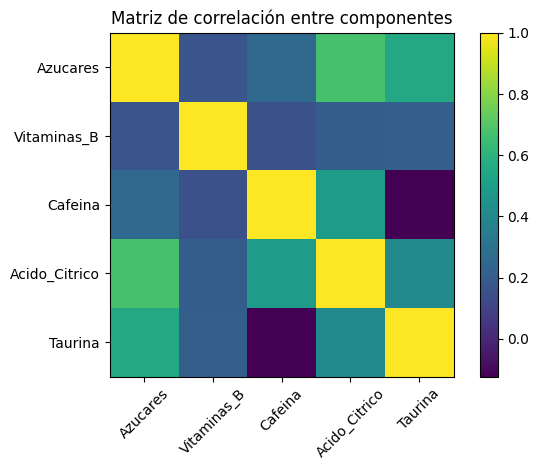

In [14]:
# Matriz de correlación
corr = df.corr()

# Visualización simple con matplotlib
plt.figure()
plt.imshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.title("Matriz de correlación entre componentes")
plt.tight_layout()
plt.show()

In [18]:
print(round(corr, 3)) 

               Azucares  Vitaminas_B  Cafeina  Acido_Citrico  Taurina
Azucares          1.000        0.174    0.258          0.673    0.553
Vitaminas_B       0.174        1.000    0.155          0.208    0.216
Cafeina           0.258        0.155    1.000          0.497   -0.124
Acido_Citrico     0.673        0.208    0.497          1.000    0.408
Taurina           0.553        0.216   -0.124          0.408    1.000


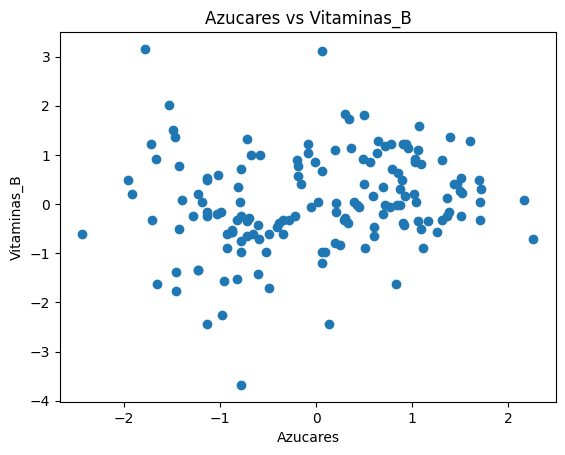

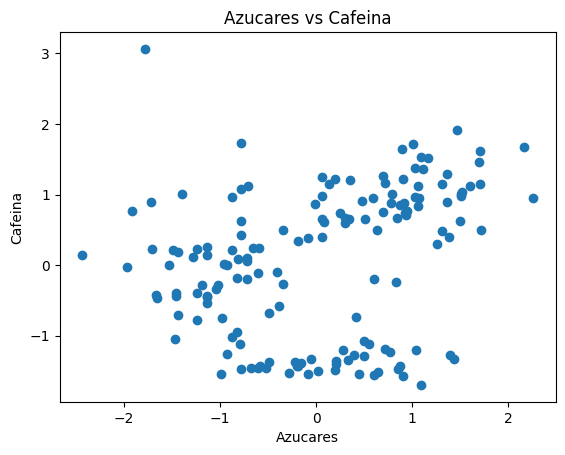

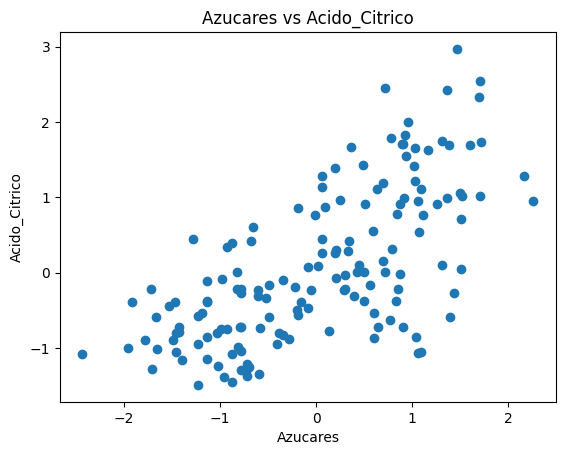

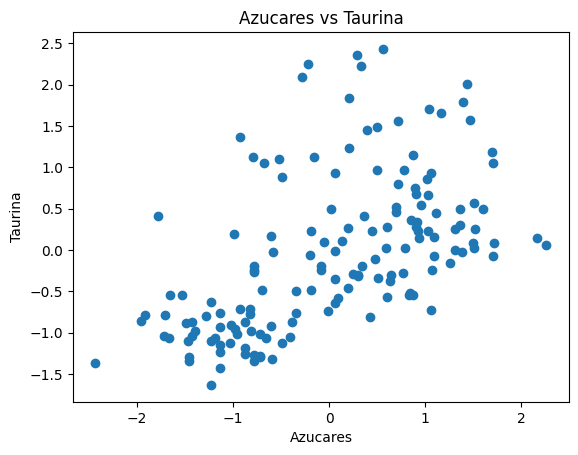

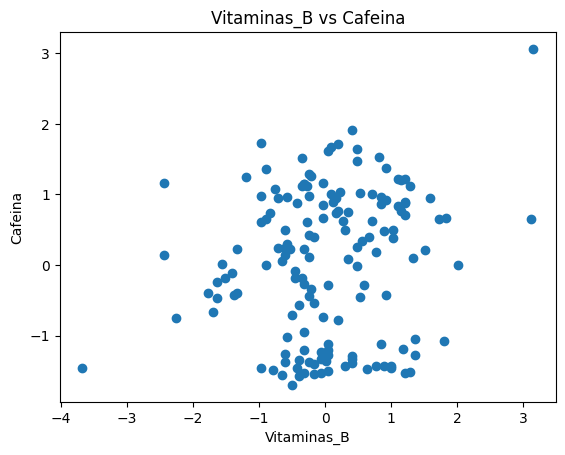

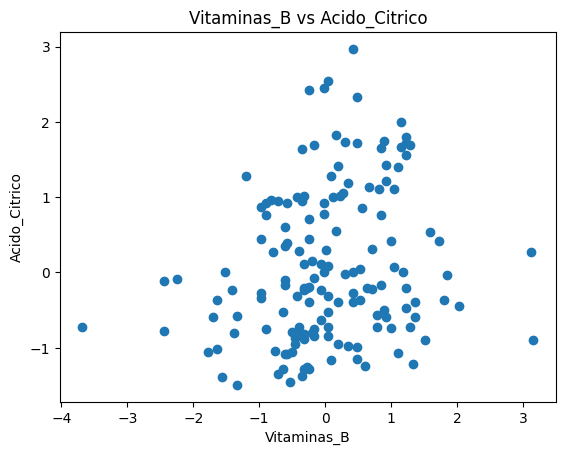

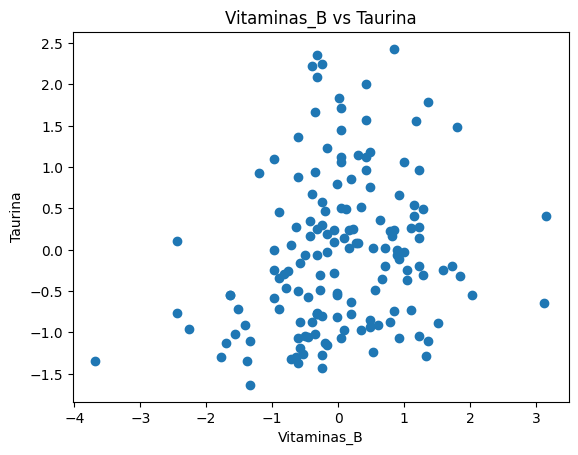

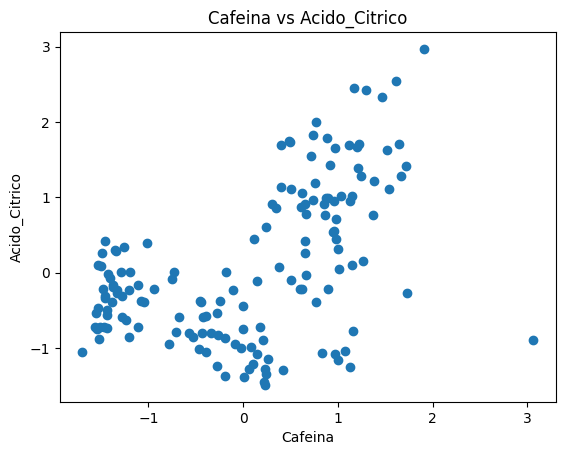

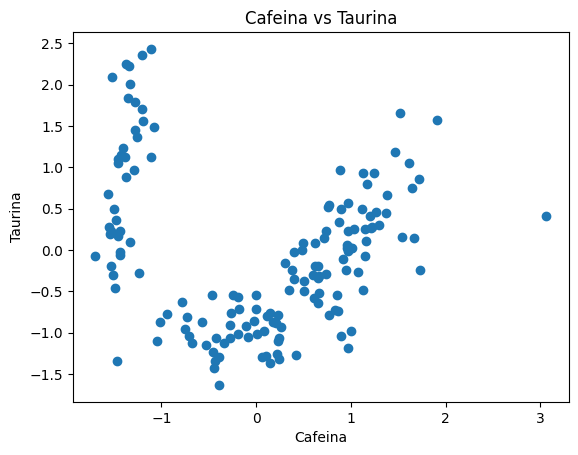

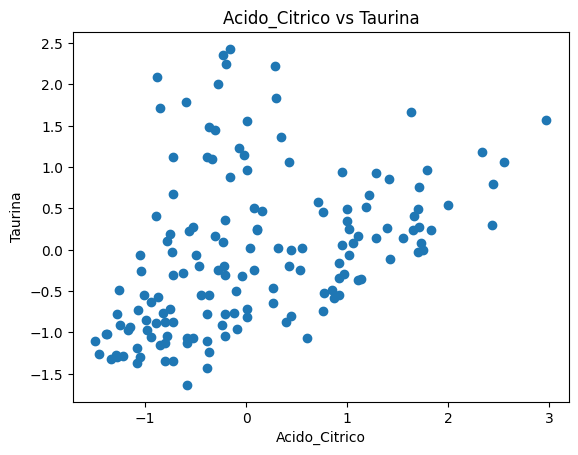

In [19]:
# Visualización 2 a 2

features = df.columns.tolist()

for i in range(len(features)):
    for j in range(i + 1, len(features)):
        plt.figure()
        plt.scatter(df[features[i]], df[features[j]])
        plt.xlabel(features[i])
        plt.ylabel(features[j])
        plt.title(f"{features[i]} vs {features[j]}")
        plt.show()

In [20]:
# Voy a coger 2 configuraciones 

# Todas las variables
X_all = df.copy()

# Con variables escogidas
selected_features = ["Cafeina", "Taurina", "Azucares"]
X_selected = df[selected_features]

In [24]:
# 4 Tratamiento de features

# Escaladores
scaler_all = StandardScaler()
scaler_selected = StandardScaler()

# Escalado
X_all_scaled = scaler_all.fit_transform(X_all)
X_selected_scaled = scaler_selected.fit_transform(X_selected)


In [25]:
print("Media (todas):", np.round(X_all_scaled.mean(axis=0), 3))
print("Std (todas):", np.round(X_all_scaled.std(axis=0), 3))

print("\nMedia (seleccionadas):", np.round(X_selected_scaled.mean(axis=0), 3))
print("Std (seleccionadas):", np.round(X_selected_scaled.std(axis=0), 3))

Media (todas): [-0.  0.  0.  0. -0.]
Std (todas): [1. 1. 1. 1. 1.]

Media (seleccionadas): [ 0. -0. -0.]
Std (seleccionadas): [1. 1. 1.]


In [29]:
# K-Means

k_values = range(2, 7)
sil_scores = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_selected_scaled)
    sil = silhouette_score(X_selected_scaled, labels)
    sil_scores.append(sil)

    print(f"K={k} → silhouette={sil:.3f}")

K=2 → silhouette=0.372
K=3 → silhouette=0.504
K=4 → silhouette=0.424
K=5 → silhouette=0.419
K=6 → silhouette=0.391


In [30]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_selected_scaled)

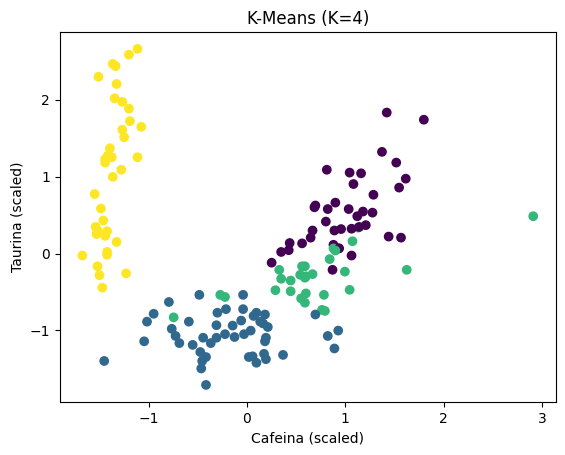

In [35]:
plt.figure()
plt.scatter(
    X_selected_scaled[:, 0],
    X_selected_scaled[:, 1],
    c=kmeans_labels
)
plt.xlabel("Cafeina (scaled)")
plt.ylabel("Taurina (scaled)")
plt.title("K-Means (K=4)")
plt.show()

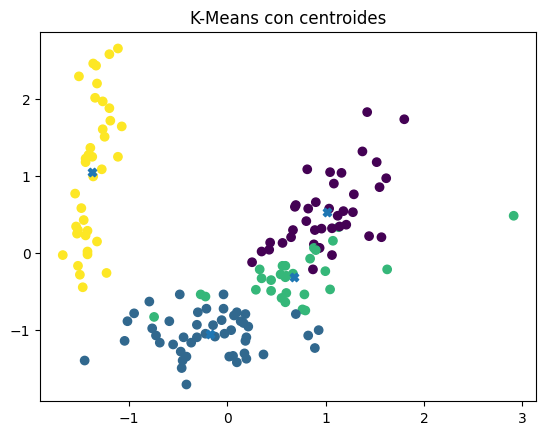

In [36]:
plt.figure()
plt.scatter(
    X_selected_scaled[:, 0],
    X_selected_scaled[:, 1],
    c=kmeans_labels
)
plt.scatter(
    kmeans.cluster_centers_[:, 0],
    kmeans.cluster_centers_[:, 1],
    marker="X"
)
plt.title("K-Means con centroides")
plt.show()

In [39]:
# DBSCAN

min_samples = 6  # 2 * 3 features

eps_values = [0.4, 0.5, 0.6, 0.7, 0.8]

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X_selected_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    print(f"eps={eps} -> clusters={n_clusters}, ruido={n_noise}")

eps=0.4 -> clusters=2, ruido=80
eps=0.5 -> clusters=3, ruido=52
eps=0.6 -> clusters=5, ruido=26
eps=0.7 -> clusters=2, ruido=13
eps=0.8 -> clusters=2, ruido=2


In [34]:
dbscan = DBSCAN(eps=0.6, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X_selected_scaled)


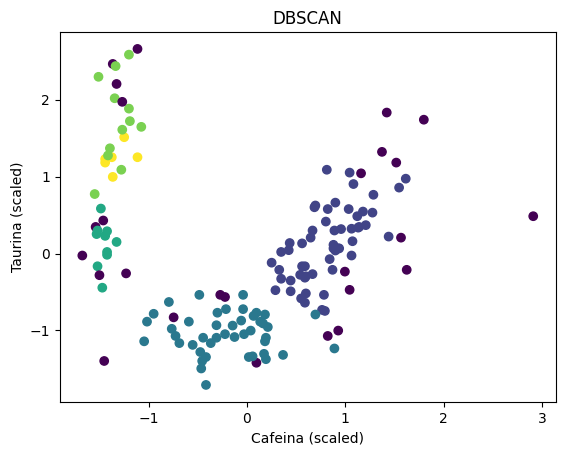

In [37]:
plt.figure()
plt.scatter(
    X_selected_scaled[:, 0],
    X_selected_scaled[:, 1],
    c=dbscan_labels
)
plt.xlabel("Cafeina (scaled)")
plt.ylabel("Taurina (scaled)")
plt.title("DBSCAN")
plt.show()


Todo esto es es especulativo porque:  
No hay target real  
No sabemos si un cluster es “mejor bebida”  
La validación es geométrica, no funcional  
Los clusters son hipótesis químicas, no verdades absolutas.

### Parte II. Nuevos experimentos

Los químicos están muy esperanzados con los modelos que les habéis mostrado y os pasan una lista de nuevos experimentos para que los clasifiquéis. Emplea uno de los modelos construidos, el que te resulte más sencillo, para segmentar los nuevos experimentos que puedes encontrar en "./data/new_experiments.csv"

In [43]:
path_new = "./data/new_experiments.csv"
df_new_raw = pd.read_csv(path_new)

df_new = df_new_raw.iloc[:, 0].str.split("|", expand=True)
df_new.columns = [
    "Azucares",
    "Vitaminas_B",
    "Cafeina",
    "Acido_Citrico",
    "Taurina"
]
df_new = df_new.astype(float)
df_new

,Azucares,Vitaminas_B,Cafeina,Acido_Citrico,Taurina
0,1.481555,0.305159,1.366128,2.239039,0.731870
1,0.616869,0.890014,0.583034,0.312420,-0.665332
2,-1.680724,0.341713,-0.340615,-0.213021,-0.976782
3,-0.284874,-1.412851,-0.782361,-1.193845,-0.717240
4,-0.927212,0.634140,-1.565455,-0.085641,-0.522583
5,0.962743,-0.243142,-1.354622,-0.420013,1.956043


In [44]:
# Mismas features
X_new = df_new[selected_features]

# Escalado con el MISMO scaler
X_new_scaled = scaler.transform(X_new)

In [45]:
df_new["Segmento_KMeans"] = kmeans.predict(X_new_scaled)

In [46]:
print("Segmentación de nuevos experimentos:")
print(df_new)

# Guardar resultados
output_path = "./data/new_experiments_segmented.csv"
df_new.to_csv(output_path, index=False)

print(f"\nArchivo guardado en: {output_path}")

Segmentación de nuevos experimentos:
   Azucares  Vitaminas_B   Cafeina  Acido_Citrico   Taurina  Segmento_KMeans
0  1.481555     0.305159  1.366128       2.239039  0.731870                0
1  0.616869     0.890014  0.583034       0.312420 -0.665332                2
2 -1.680724     0.341713 -0.340615      -0.213021 -0.976782                1
3 -0.284874    -1.412851 -0.782361      -1.193845 -0.717240                1
4 -0.927212     0.634140 -1.565455      -0.085641 -0.522583                1
5  0.962743    -0.243142 -1.354622      -0.420013  1.956043                3

Archivo guardado en: ./data/new_experiments_segmented.csv


### Parte III. EXTRA (Voluntario): 6 meses después...

La unidad de experimentación recibió un presupuesto adicional gracias a los modelos que les proporcionastes e hizo pruebas con cliente y obtuvo resultados como para clasificar cada bebida en terminos de "energización" en tres niveles (1, media; 2, media-alta, 3, alta). El resultado de los mismos está en el fichero adecuado en el directorio data y alineado con los experimentos iniciales y al final con los nuevos experimentos de la parte anterior.

Evalua la segmentación de los modelos creados en la primera parte.